In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchsde
import torchdyn
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import torch
import torch.nn as nn

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *

import netCDF4
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
def rescale(x):
    return (x - x.min()) / (x.max() - x.min())

def torch_cdf(x):
    x = x.squeeze()
    x = x.reshape(-1, 1)
    z = torch.linspace(0, 1, 100)
    cdf = torch.mean(1.0*(x <= z), axis = 0)
    cdf = rescale(cdf)
    return cdf

def torch_w2(x, y):
    x = x.squeeze()
    y = y.squeeze()

    z = torch.linspace(0+1e-3, 1-1e-3, 100)
    qx = torch.quantile(x, z)
    qy = torch.quantile(y, z)

    return torch.sqrt(torch.mean((qx - qy)**2))
    

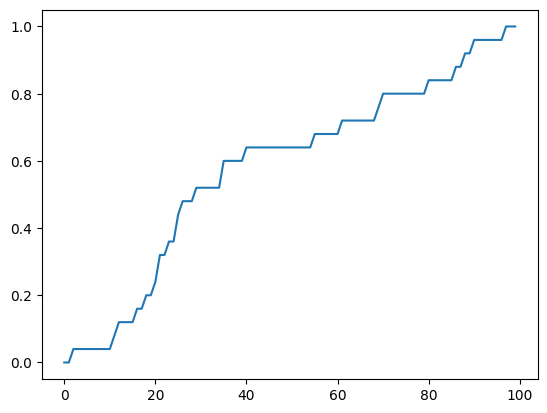

In [3]:
# generate data
torch.random.manual_seed(420)
x = torch.rand((25, 1))
data_cdf = torch_cdf(x)
plt.plot(data_cdf)

In [4]:
model = MLP(dim=1, w=256, time_varying=True)
model = model.to(device)
node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)

In [5]:
trace = []
n_epochs = 50000
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut)**2)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    trace.append(loss.detach().cpu())

    if loss < 1e-3:
        break

  0%|          | 0/50000 [00:00<?, ?it/s]

In [6]:
with torch.no_grad():
        traj = node.trajectory(
             torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

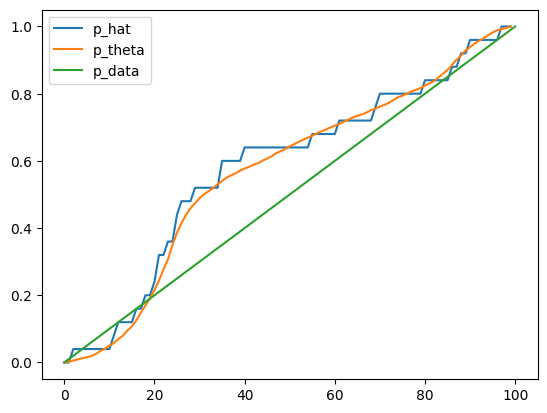

In [7]:
data_cdf = torch_cdf(x)
theta_cdf = torch_cdf(traj)
plt.plot(data_cdf, label = 'p_hat')
plt.plot(theta_cdf, label = 'p_theta')
plt.plot([0, 100], [0, 1], label = 'p_data')
plt.legend()
plt.show()

In [60]:
def laplace_clone(model):
    import copy
    with torch.no_grad():
        model_la = copy.deepcopy(model)
        for param in model_la.parameters():
            param.add_(torch.randn(param.size()).to(device) * 0.005) 
    return model_la

In [61]:
# extremely illegal laplace clones
node0 = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

model_la1 = laplace_clone(model)
model_la2 = laplace_clone(model)

node1 = NeuralODE(torch_wrapper(model_la1), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
node2 = NeuralODE(torch_wrapper(model_la2), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [62]:
with torch.no_grad():
        traj0 = node0.trajectory(
             torch.randn((5000, 1)).to(device),
             t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

        traj1 = node1.trajectory(
             torch.randn((5000, 1)).to(device),
             t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

        traj2 = node2.trajectory(
             torch.randn((5000, 1)).to(device),
             t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

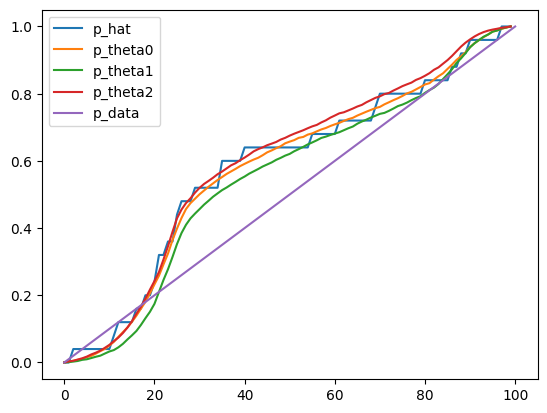

In [63]:
data_cdf = torch_cdf(x)
theta0_cdf = torch_cdf(traj0)
theta1_cdf = torch_cdf(traj1)
theta2_cdf = torch_cdf(traj2)
plt.plot(data_cdf, label = 'p_hat')
plt.plot(theta0_cdf, label = 'p_theta0')
plt.plot(theta1_cdf, label = 'p_theta1')
plt.plot(theta2_cdf, label = 'p_theta2')
plt.plot([0, 100], [0, 1], label = 'p_data')
plt.legend()
plt.show()

In [64]:
traj = []
cdfs = []
for _ in trange(50):
    with torch.no_grad():
        node_la = NeuralODE(torch_wrapper(laplace_clone(model)), 
                            solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        traj_la = node_la.trajectory(
            torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

        traj.append(traj_la)
        cdfs.append(torch_cdf(traj_la))

  0%|          | 0/50 [00:00<?, ?it/s]

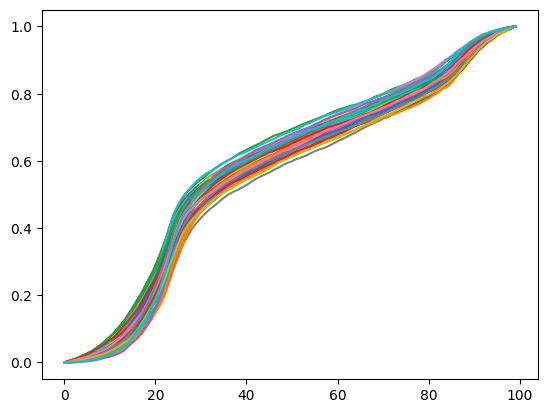

In [65]:
for cdf in cdfs:
    plt.plot(cdf, label = 'p_theta0')

In [12]:
def cfm_loss(model, x):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut)**2)
    return loss

In [50]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters

class LaplaceApproximation:
    def __init__(self, model, loss_fn=cfm_loss, structure='diag', last_layer_only=True):
        self.model = model
        self.loss_fn = loss_fn
        self.structure = structure  # 'diag' or 'lowrank'
        self.last_layer_only = last_layer_only

        if last_layer_only:
            self.params = list(self._get_last_layer(model).parameters())
        else:
            self.params = list(model.parameters())
            
        self.mean = parameters_to_vector(self.params).detach()
        self.hessian_approx = None
        self.prior_precision = 1.0  # Gaussian prior
        
    def _get_last_layer(self, model):
        # Works for nn.Sequential or manually defined layers
        last_layer = None
        for module in reversed(list(model.modules())):
            if isinstance(module, nn.Linear):
                last_layer = module
                break
        if last_layer is None:
            raise ValueError("No linear layer found in model.")
        return last_layer

    def fit(self, x, num_samples=20):
        self.model.zero_grad()
        loss = self.loss_fn(model, x)
        grads = torch.autograd.grad(loss, self.params, create_graph=True)
        grad_vec = torch.cat([g.view(-1) for g in grads])

        if self.structure == 'diag':
            diag_hess = []
            for i in range(grad_vec.numel()):
                grad2 = torch.autograd.grad(grad_vec[i], self.params, retain_graph=True)
                h_i = torch.cat([g.view(-1) for g in grad2])[i].detach()
                diag_hess.append(h_i)
            self.hessian_approx = torch.stack(diag_hess)

        elif self.structure == 'lowrank':
            param_dim = grad_vec.numel()
            V = []
            for _ in range(num_samples):
                v = torch.randn(param_dim)
                Hv = self._hvp(x, v)
                V.append(Hv.unsqueeze(1))
            self.hessian_approx = torch.cat(V, dim=1)  # (D, K)

    def _hvp(self, x, v):
        v = v.to(device)
        self.model.zero_grad()
        loss = self.loss_fn(model, x)
        grads = torch.autograd.grad(loss, self.params, create_graph=True)
        grad_flat = torch.cat([g.view(-1) for g in grads])
        grad_v = torch.dot(grad_flat, v)
        Hv = torch.autograd.grad(grad_v, self.params)
        return torch.cat([h.view(-1) for h in Hv]).detach()

    def sample_posterior(self, num_samples=1):
        if self.structure == 'diag':
            precision = self.hessian_approx + self.prior_precision
            std = torch.sqrt(1.0 / precision)
            eps = torch.randn(num_samples, std.numel()).to(device)
            samples = self.mean + eps * std
            return samples

        elif self.structure == 'lowrank':
            V = self.hessian_approx  # shape (D, K)
            D, K = V.shape
            prior_prec_I = self.prior_precision * torch.eye(D).to(device)
            approx_hess = V @ V.T + prior_prec_I
            cov = torch.inverse(approx_hess)
            eps = torch.randn(num_samples, D).to(device)
            samples = self.mean + eps @ cov.cholesky()
            return samples
            
    def sample_model(self):
        """Return a new model with one sample from the Laplace posterior."""
        # Clone the original model structure
        # sampled_model = type(self.model)()
        # sampled_model.load_state_dict(self.model.state_dict())  # copy weights

        import copy
        with torch.no_grad():
            sampled_model = copy.deepcopy(self.model)

        # Sample new weights for Laplace-tracked parameters
        sampled_params = self.sample_posterior(num_samples=1)[0]
        # vector_to_parameters(sampled_params, self.params)

        # Now copy the sampled params into the sampled_model
        # Important: only overwrite the last layer if last_layer_only is set
        if self.last_layer_only:
            target_layer = self._get_last_layer(model)
            source_layer = self._get_last_layer(sampled_model)

            # Copy the sampled weights
            source_params = list(source_layer.parameters())
            for p, s in zip(self.params, source_params):
                s.data.copy_(p.data)

        else:
            vector_to_parameters(sampled_params, sampled_model.parameters())

        return sampled_model

In [51]:
la = LaplaceApproximation(model, structure='diag')
la.fit(x, num_samples=100)

In [52]:
node0 = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

model_la1 = la.sample_model()
node1 = NeuralODE(torch_wrapper(model_la1), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

model_la2 = la.sample_model()
node2 = NeuralODE(torch_wrapper(model_la2), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [53]:
with torch.no_grad():
        traj0 = node0.trajectory(
             torch.randn((5000, 1)).to(device),
             t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

        traj1 = node1.trajectory(
             torch.randn((5000, 1)).to(device),
             t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

        traj2 = node2.trajectory(
             torch.randn((5000, 1)).to(device),
             t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

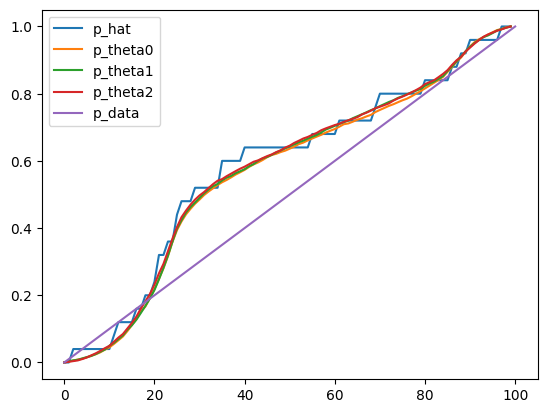

In [54]:
data_cdf = torch_cdf(x)
theta0_cdf = torch_cdf(traj0)
theta1_cdf = torch_cdf(traj1)
theta2_cdf = torch_cdf(traj2)
plt.plot(data_cdf, label = 'p_hat')
plt.plot(theta0_cdf, label = 'p_theta0')
plt.plot(theta1_cdf, label = 'p_theta1')
plt.plot(theta2_cdf, label = 'p_theta2')
plt.plot([0, 100], [0, 1], label = 'p_data')
plt.legend()
plt.show()

In [56]:
traj = []
cdfs = []
for _ in trange(50):
    with torch.no_grad():
        node_la = NeuralODE(torch_wrapper(la.sample_model()), 
                            solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        traj_la = node_la.trajectory(
            torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

        traj.append(traj_la)
        cdfs.append(torch_cdf(traj_la))

  0%|          | 0/50 [00:00<?, ?it/s]

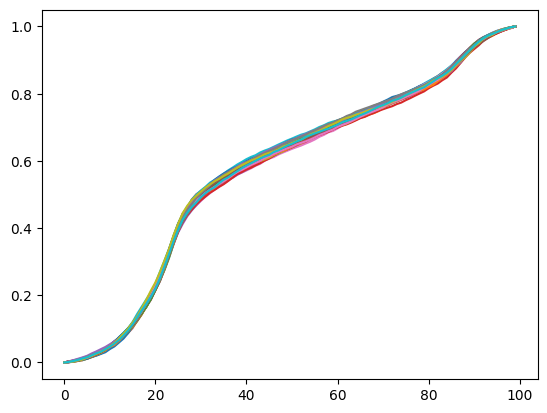

In [57]:
for cdf in cdfs:
    plt.plot(cdf, label = 'p_theta0')

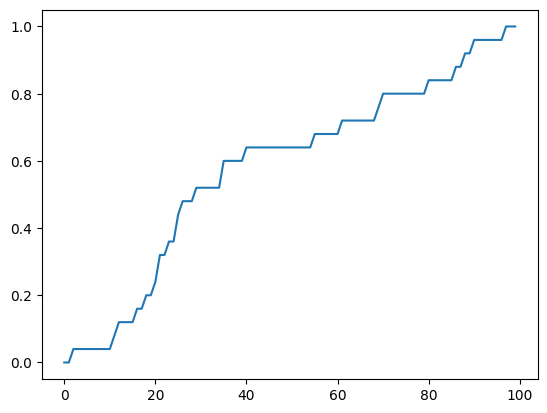

In [18]:
# generate data
torch.random.manual_seed(420)
x = torch.rand((25, 1))
data_cdf = torch_cdf(x)
plt.plot(data_cdf)

In [14]:
# image 1 - error < 1
model0 = MLP(dim=1, w=512, time_varying=True)
model0 = model0.to(device)
node0 = NeuralODE(torch_wrapper(model0), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
optimizer0 = torch.optim.Adam(model0.parameters())

# image 2 - error < 1e-1
model1 = MLP(dim=1, w=512, time_varying=True)
model1 = model1.to(device)
node1 = NeuralODE(torch_wrapper(model1), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
optimizer1 = torch.optim.Adam(model1.parameters())

# image 3 - error < 1e-2
model2 = MLP(dim=1, w=512, time_varying=True)
model2 = model2.to(device)
node2 = NeuralODE(torch_wrapper(model2), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters())

# image 4 - error < 1e-3
model3 = MLP(dim=1, w=512, time_varying=True)
model3 = model3.to(device)
node3 = NeuralODE(torch_wrapper(model3), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
optimizer3 = torch.optim.Adam(model3.parameters())

# Assumed OT flow
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)

In [15]:
n_epochs = 50000
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model0(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut)**2)
        
    loss.backward()
    optimizer0.step()
    optimizer0.zero_grad()

    if loss < 1:
        break

  0%|          | 0/50000 [00:00<?, ?it/s]

In [16]:
n_epochs = 50000
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model1(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut)**2)
        
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()

    if loss < 1e-1:
        break

  0%|          | 0/50000 [00:00<?, ?it/s]

In [17]:
n_epochs = 50000
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model2(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut)**2)
        
    loss.backward()
    optimizer2.step()
    optimizer2.zero_grad()

    if loss < 1e-2:
        break

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
n_epochs = 50000
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model3(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut)**2)
        
    loss.backward()
    optimizer3.step()
    optimizer3.zero_grad()

    if loss < 1e-3:
        break

  0%|          | 0/50000 [00:00<?, ?it/s]

In [20]:
with torch.no_grad():
        traj0 = node0.trajectory(
             torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

with torch.no_grad():
        traj1 = node1.trajectory(
             torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

with torch.no_grad():
        traj2 = node2.trajectory(
             torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

with torch.no_grad():
        traj3 = node3.trajectory(
             torch.randn((5000, 1)).to(device),
            t_span=torch.linspace(0, 1, 100),
        )[-1,:,0].cpu()

In [75]:
torch.random.manual_seed(420)
x_data = torch.rand((5000, 1))
# data_cdf = torch_cdf(x_data)
# plt.plot(data_cdf)

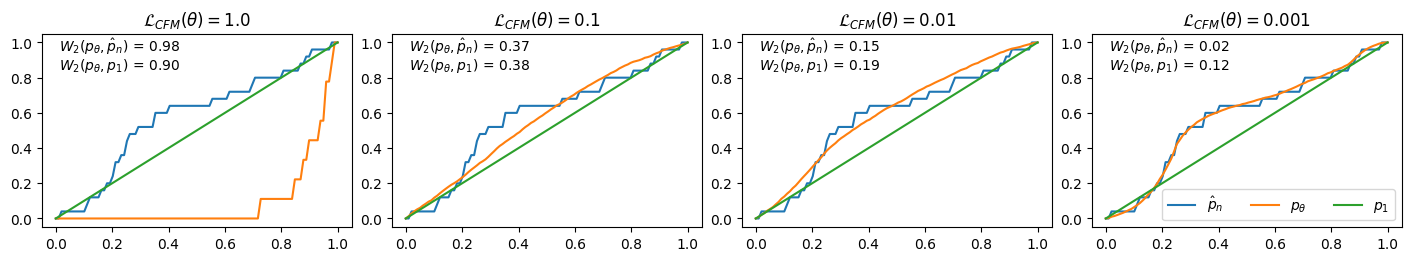

In [99]:
data_cdf = torch_cdf(x)
theta_cdf0 = torch_cdf(traj0)
theta_cdf1 = torch_cdf(traj1)
theta_cdf2 = torch_cdf(traj2)
theta_cdf3 = torch_cdf(traj3)
theta_cdfs = [theta_cdf0, theta_cdf1, theta_cdf2, theta_cdf3]

trajs = [traj0, traj1, traj2, traj3]
losses = [1e0, 1e-1, 1e-2, 1e-3]

fig, ax = plt.subplots(1, 4, constrained_layout = True, figsize = (14, 2.5))

t = np.linspace(0, 1, 100)
for i in range(4):
    ax[i].plot(t, data_cdf, label = '$\\hat{p}_n$')
    ax[i].plot(t, theta_cdfs[i], label = '$p_\\theta$')
    ax[i].plot([0, 1], [0, 1], label = '$p_1$')
    ax[i].text(0.01, 0.95, '$W_2(p_\\theta, \\hat{p}_n$) = ' + f'{torch_w2(x, trajs[i]):.2f}')
    ax[i].text(0.01, 0.85, '$W_2(p_\\theta, p_1$) = ' + f'{torch_w2(x_data, trajs[i]):.2f}')
    ax[i].set_title('$\\mathcal{L}_{CFM}(\\theta) =$' + str(losses[i]))
    if i == 3:
        ax[i].legend(ncol = 3)
        
plt.savefig('cfm_converge.png')
plt.show()

In [4]:
mu = torch.tensor((3, 3)).reshape(-1, 2)
sig1 = torch.tensor((1, 0.8, 0.8, 1)).reshape(2, 2)
sig2 = torch.tensor((1, -0.8, -0.8, 1)).reshape(2, 2)

x1 = mu + torch.randn((500, 2)) @ sig1
x2 = mu + torch.randn((500, 2)) @ sig2
x = torch.vstack([x1, x2])

z = 0.2*torch.randn((1000, 2))

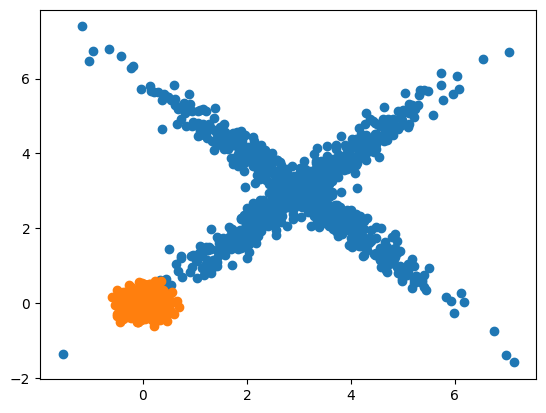

In [5]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(z[:,0], z[:,1])

In [6]:
def tensorize(t):
    if not torch.is_tensor(t):
        t = torch.tensor([t], device=x.device)
        
    if t.dim() == 0:
        t = t.expand(x.size(0), 1)
    elif t.dim() == 1:
        t = t[:, None]
    return t

In [7]:
class varflow(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Linear(2, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 2)
        )

    def forward(self, t, x):
        t = tensorize(t)
        x = x + t
        return self.enc(x)

In [8]:
model = varflow()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)

In [9]:
trace = []
n_epochs = 500
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt = model(t, xt)
    loss = torch.mean((vt - ut)**2)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    trace.append(loss.detach().cpu())

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
with torch.no_grad():
    samp = torch.randn_like(x).to(device)
    t_seq = torch.linspace(0, 1, 100)
    h = torch.diff(t_seq)[0]
    for t in tqdm(t_seq):
        samp += h*model(t.to(device), samp)
    samp = samp.detach().cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

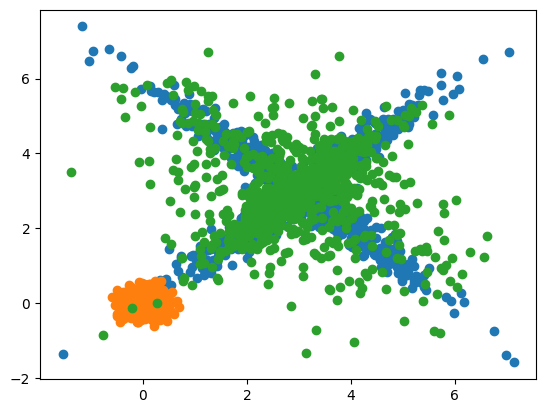

In [11]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(z[:,0], z[:,1])
plt.scatter(samp[:,0], samp[:,1])

In [12]:
def kldiv(mu, sig):
    mu_norm = torch.mean(mu**2, axis = 1)
    trace_sig = torch.mean(sig, axis = 1)
    logdet_sig = torch.mean(torch.log(sig), axis = 1)
    return torch.mean(mu_norm + trace_sig - logdet_sig)

In [13]:
class varflow(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Linear(2, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 40)
        )
        
        self.dec = nn.Sequential(
            nn.Linear(20, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 132), nn.Tanh(),
            nn.Linear(132, 2)
        )

    def encode(self, t, x):
        t = tensorize(t)
        x = x + t
        theta = self.enc(x)
        
        mu = theta[:,0:20]
        sig = nn.Softplus()(theta[:,20:])
        return mu, sig

    def decode(self, t, z):
        t = tensorize(t)
        z = z + t
        x = self.dec(z)
        return x

    def forward(self, t, x):
        mu, sig = self.encode(t, x)
        z = mu + sig * torch.randn_like(mu)
        x = self.decode(t, z)
        return x, mu, sig

In [14]:
model = varflow()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=0.0)

In [15]:
trace = []
n_epochs = 1000
for epoch in trange(n_epochs):
    x1 = x.to(device)
    x0 = torch.randn_like(x).to(device)
    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    vt, mu, sig = model(t, xt)
    # mu, sig = model.encode(t, xt)
    loss = torch.mean((vt - ut)**2) + 0.1 * kldiv(mu, sig)
        
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    trace.append(loss.detach().cpu())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
torch.manual_seed(23)
x0 = torch.randn_like(x)

samp1 = x0.to(device)
samp2 = x0.to(device)

In [17]:
torch.manual_seed(23)
x0 = torch.randn_like(x)

samp1 = x0.to(device)
samp2 = x0.to(device)

with torch.no_grad():
    t_seq = torch.linspace(0, 1, 100).to(device)
    h = torch.diff(t_seq)[0].item()
    for t in tqdm(t_seq):
        torch.manual_seed(1)
        samp1 += h * model(t, samp1)[0]

    samp1 = samp1.detach().cpu()

with torch.no_grad():
    t_seq = torch.linspace(0, 1, 100).to(device)
    h = torch.diff(t_seq)[0].item()
    for t in tqdm(t_seq):
        torch.manual_seed(2)
        samp2 += h * model(t, samp2)[0]

    samp2 = samp2.detach().cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

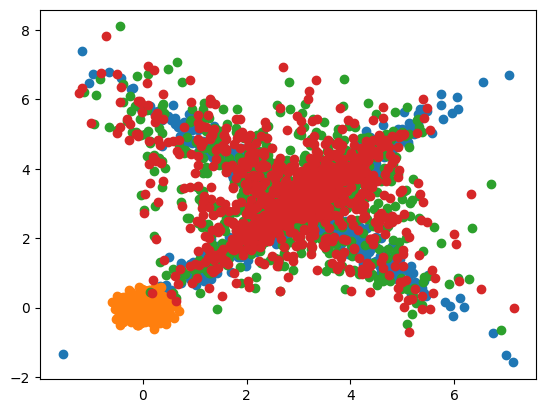

In [18]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(z[:,0], z[:,1])
plt.scatter(samp1[:,0], samp1[:,1])
plt.scatter(samp2[:,0], samp2[:,1])

In [19]:
torch.std(samp1 - samp2, axis = 0)

tensor([0.1320, 0.1421])

In [20]:
torch.manual_seed(1001)
samp1 = torch.randn_like(x).to(device)
samp2 = torch.randn_like(x).to(device)

with torch.no_grad():
    t_seq = torch.linspace(0, 1, 100).to(device)
    h = torch.diff(t_seq)[0].item()
    for t in tqdm(t_seq):
        torch.manual_seed(1)
        samp1 += h * model(t, samp1)[0]

    samp1 = samp1.detach().cpu()

with torch.no_grad():
    t_seq = torch.linspace(0, 1, 100).to(device)
    h = torch.diff(t_seq)[0].item()
    for t in tqdm(t_seq):
        torch.manual_seed(2)
        samp2 += h * model(t, samp2)[0]

    samp2 = samp2.detach().cpu()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

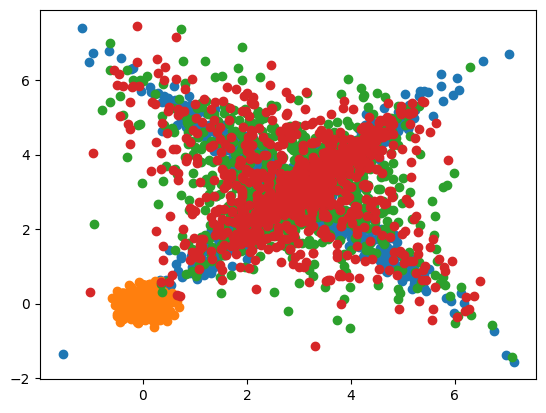

In [21]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(z[:,0], z[:,1])
plt.scatter(samp1[:,0], samp1[:,1])
plt.scatter(samp2[:,0], samp2[:,1])

In [63]:
samp1 = integrate(model, dim, seed = 1)
samp2 = integrate(model, dim, seed = 2)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

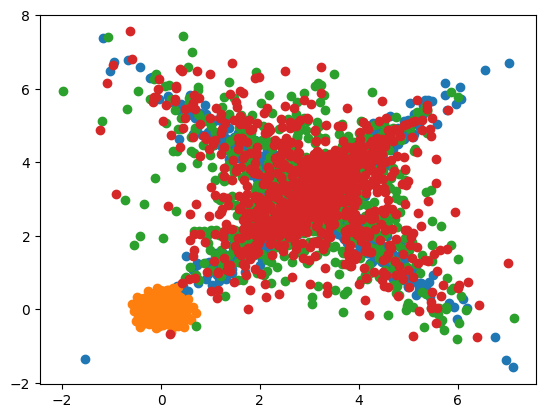

In [64]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(z[:,0], z[:,1])
plt.scatter(samp1[:,0], samp1[:,1])
plt.scatter(samp2[:,0], samp2[:,1])

In [ ]:
### doesnt quite work

In [81]:
def reverse_integrate(model, x, seed = 0, t_steps = 100):
    samp = x.to(device)
    with torch.no_grad():
        t_seq = torch.linspace(1, 0, 100).to(device)
        eps = torch.diff(t_seq)[0].item()
        for t in tqdm(t_seq):
            torch.manual_seed(seed)
            samp += eps * model(t, samp)[0]

    return samp.detach().cpu()

In [82]:
rev1 = reverse_integrate(model, x, seed = 1)
rev2 = reverse_integrate(model, x, seed = 2)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

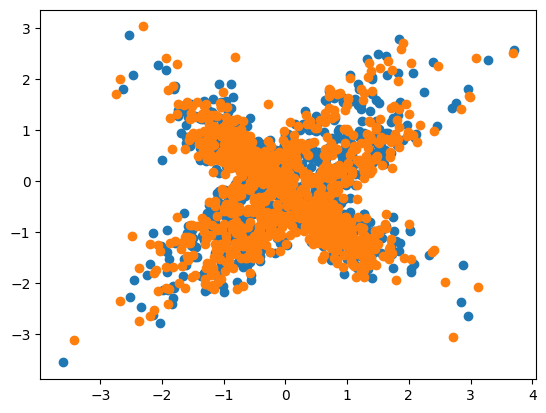

In [86]:
plt.scatter(x[:,0], x[:,1])
plt.scatter(z[:,0], z[:,1])
plt.scatter(rev1[:,0], rev1[:,1])
plt.scatter(rev2[:,0], rev2[:,1])

In [193]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import netCDF4
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")